Loading required package: coda

Linked to JAGS 4.3.0

Loaded modules: basemod,bugs


Attaching package: ‘R2jags’


The following object is masked from ‘package:coda’:

    traceplot



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: Rcpp

This is rstanarm version 2.21.1

- See https://mc-stan.org/rstanarm/articles/priors for changes to default priors!

- Default priors may change, so it's safest to specify priors, even if equivalent to the defaults.

- For execution on a local, multicore CPU with excess RAM we recommend calling

  options(mc.cores = parallel::detectCores())



         
            Neg   Pos
  Placebo 12621   260
  Vaccine 12735    95

Warning message:
“No initial values were provided - JAGS will use the same initial values for all chains”
Warning message:
“You attempted to start parallel chains without setting different PRNG for each chain, which is not recommended.  Different .RNG.name values have been added to each set of initial values.”


Calling 4 simulations using the parallel method...
Following the progress of chain 1 (the program will wait for all chains
to finish before continuing):
Welcome to JAGS 4.3.0 on Wed Jun 23 13:19:27 2021
JAGS is free software and comes with ABSOLUTELY NO WARRANTY
Loading module: basemod: ok
Loading module: bugs: ok
. . Reading data file data.txt
. Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 25711
   Unobserved stochastic nodes: 2
   Total graph size: 51431
. Reading parameter file inits1.txt
. Initializing model
. Adaptation skipped: model is not in adaptive mode.
. Updating 4000
-------------------------------------------------| 4000
************************************************** 100%
. . Updating 20000
-------------------------------------------------| 20000
************************************************** 100%
. . . . Updating 0
. Deleting model
. 
All chains have finished
Note: the model did not r

,Lower95,Median,Upper95,Mean,SD,Mode,MCerr,MC%ofSD,SSeff,AC.10,psrf
theta[1],0.01784990,0.020229000,0.02273040,0.020256219,0.0012448065,NA,6.224033e-06,0.5,40000,-0.0035101222,1.000078
theta[2],0.00608733,0.007547185,0.00906913,0.007576434,0.0007633172,NA,3.817086e-06,0.5,39990,-0.0001976381,1.000020
theta[3],53.61690000,62.660450000,70.85460000,62.457208510,4.4246274670,NA,2.212528e-02,0.5,39992,0.0012163865,1.000058


Calculating summary statistics...
Calculating the Gelman-Rubin statistic for 3 variables....



JAGS model summary statistics from 80000 samples (chains = 4; adapt+burnin = 5000):
                                                                           
           Lower95    Median   Upper95      Mean         SD Mode      MCerr
theta[1]  0.017868   0.02023  0.022741  0.020254  0.0012419   --  4.387e-06
theta[2] 0.0060869 0.0075501 0.0090655 0.0075766 0.00076272   -- 2.6896e-06
theta[3]    53.574    62.668    70.832    62.453     4.4245   --   0.015604
                                         
         MC%ofSD SSeff       AC.10   psrf
theta[1]     0.4 80136  -0.0035101 1.0001
theta[2]     0.4 80415 -0.00019764 1.0001
theta[3]     0.4 80394   0.0012164 1.0001

Total time taken: 1.5 minutes


,Parameter,MAP,CI,CI_low,CI_high,pd
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Posterior,63.23133,0.95,53.57364,70.83172,1


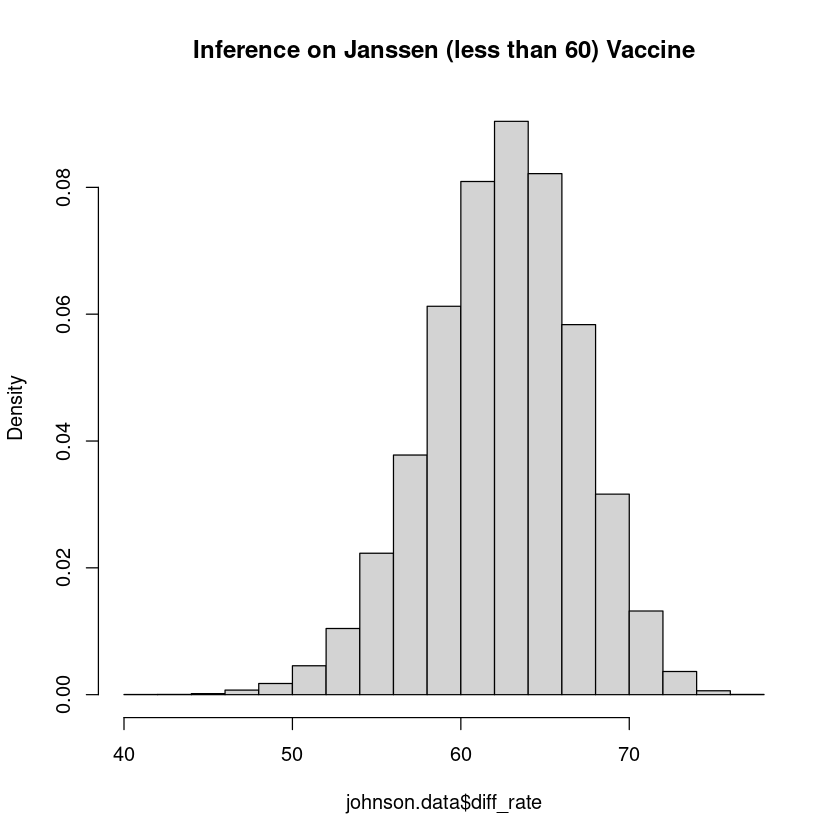

In [1]:
### age less than 60

library(rjags)
library(runjags)
library(R2jags)
library(tidybayes)
library(dplyr)
library(coda)
library(rstanarm)
library(plotrix)
library(dupiR)

tot_vaccine <- 12830
tot_placebo <- 12881
patient <- c(rep("Vaccine", tot_vaccine),
             rep("Placebo", tot_placebo))
# Number of patients tested postive after RCT:
pos_vaccine <- 95
pos_placebo <- 260
tested   <- c(rep("Pos", pos_vaccine),
              rep("Neg", tot_vaccine - pos_vaccine),
              rep("Pos", pos_placebo),
              rep("Neg", tot_placebo - pos_placebo))
johnson.tb <- tibble::tibble(tested = tested, patient=patient)
table(johnson.tb[[2]], johnson.tb[[1]])

dataList = list(
    tested = ifelse(johnson.tb$tested == "Neg", 0, 1),
    patient = as.integer(factor(johnson.tb$patient)),
    Ntot = nrow(johnson.tb) ,
    Nclass = nlevels(factor(johnson.tb$patient))
)

modelString <- "  
  model {
    for ( i in 1:Ntot ) {
      tested[i] ~ dbern( theta[patient[i]] )
    }
  for ( k in 1:Nclass ) {
    theta[k] ~ dbeta(3 , 100)    
    }
  theta[3] = (theta[1]-theta[2])/theta[1] * 100
  }"
writeLines(modelString , con="jags_Janssen_model.txt")

johnson_chains <- run.jags(modelString ,
                          sample = 20000,
                          n.chains = 4,
                          method = "parallel",
                          monitor = "theta",
                          data = dataList)

summary(johnson_chains)
add.summary(johnson_chains)

johnson_res    <- tidybayes::tidy_draws(johnson_chains) %>%
                 select('theta[1]':'theta[2]') %>%
                 rename(Placebo = 'theta[1]', Vaccine = 'theta[2]') %>%
                 mutate(diff_rate = (Placebo - Vaccine) / Placebo * 100,
                        Placebo_perc = Placebo * 100,
                        Vaccine_perc = Vaccine * 100)

johnson.mcmc <- as.mcmc(johnson_res)
johnson.data <- as.data.frame(johnson.mcmc)

hist(johnson.data$diff_rate,freq=FALSE,main='Inference on Janssen (less than 60) Vaccine')

bayestestR::describe_posterior(johnson.data$diff_rate,
                               ci=0.95,
                               test=c("p_direction"),
                               centrality="map")

         
           Neg  Pos
  Placebo 6722   88
  Vaccine 6779   21

Warning message:
“No initial values were provided - JAGS will use the same initial values for all chains”
Warning message:
“You attempted to start parallel chains without setting different PRNG for each chain, which is not recommended.  Different .RNG.name values have been added to each set of initial values.”


Calling 4 simulations using the parallel method...
Following the progress of chain 1 (the program will wait for all chains
to finish before continuing):
Welcome to JAGS 4.3.0 on Wed Jun 23 13:21:02 2021
JAGS is free software and comes with ABSOLUTELY NO WARRANTY
Loading module: basemod: ok
Loading module: bugs: ok
. . Reading data file data.txt
. Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 13610
   Unobserved stochastic nodes: 2
   Total graph size: 27229
. Reading parameter file inits1.txt
. Initializing model
. Adaptation skipped: model is not in adaptive mode.
. Updating 4000
-------------------------------------------------| 4000
************************************************** 100%
. . Updating 20000
-------------------------------------------------| 20000
************************************************** 100%
. . . . Updating 0
. Deleting model
All chains have finished
Note: the model did not requ

,Lower95,Median,Upper95,Mean,SD,Mode,MCerr,MC%ofSD,SSeff,AC.10,psrf
theta[1],0.01054470,0.013126450,0.01588520,0.013168265,0.001371582,NA,6.767853e-06,0.5,41072,-0.0007643283,0.9999841
theta[2],0.00212174,0.003425695,0.00485895,0.003478399,0.000706373,NA,3.549144e-06,0.5,39611,-0.0002325614,1.0000132
theta[3],60.95470000,73.890250000,84.57200000,73.290937412,6.160850617,NA,3.080425e-02,0.5,40000,0.0011380495,1.0000335


Calculating summary statistics...
Calculating the Gelman-Rubin statistic for 3 variables....



JAGS model summary statistics from 80000 samples (chains = 4; adapt+burnin = 5000):
                                                                          
           Lower95    Median   Upper95     Mean         SD Mode      MCerr
theta[1]  0.010527  0.013121  0.015875 0.013165   0.001374   -- 4.8323e-06
theta[2] 0.0021687 0.0034271 0.0049015 0.003478 0.00070573   -- 2.5403e-06
theta[3]    60.797    73.869    84.402   73.286     6.1641   --   0.022011
                                       
         MC%ofSD SSeff       AC.10 psrf
theta[1]     0.4 80846 -0.00076433    1
theta[2]     0.4 77180 -0.00023256    1
theta[3]     0.4 78427    0.001138    1

Total time taken: 47.3 seconds


,Parameter,MAP,CI,CI_low,CI_high,pd
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Posterior,74.6336,0.95,60.79653,84.40239,1


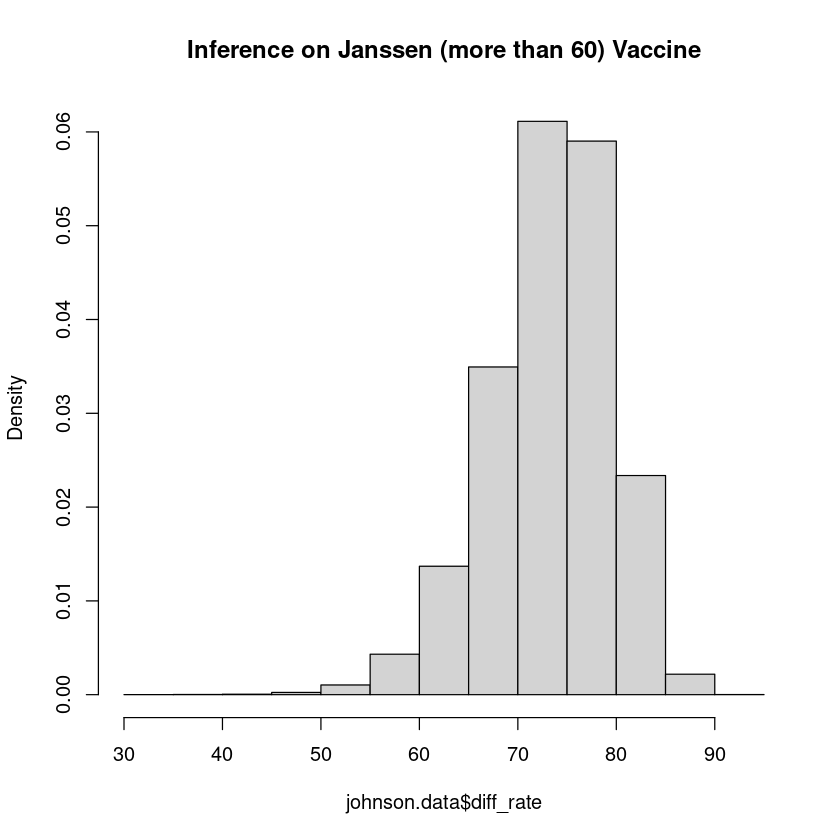

In [2]:
### age more than 60


tot_vaccine <- 6800
tot_placebo <- 6810
patient <- c(rep("Vaccine", tot_vaccine),
             rep("Placebo", tot_placebo))
# Number of patients tested postive after RCT:
pos_vaccine <- 21
pos_placebo <- 88
tested   <- c(rep("Pos", pos_vaccine),
              rep("Neg", tot_vaccine - pos_vaccine),
              rep("Pos", pos_placebo),
              rep("Neg", tot_placebo - pos_placebo))
johnson.tb <- tibble::tibble(tested = tested, patient=patient)
table(johnson.tb[[2]], johnson.tb[[1]])

dataList = list(
    tested = ifelse(johnson.tb$tested == "Neg", 0, 1),
    patient = as.integer(factor(johnson.tb$patient)),
    Ntot = nrow(johnson.tb) ,
    Nclass = nlevels(factor(johnson.tb$patient))
)

modelString <- "  
  model {
    for ( i in 1:Ntot ) {
      tested[i] ~ dbern( theta[patient[i]] )
    }
  for ( k in 1:Nclass ) {
    theta[k] ~ dbeta(3 , 100)    
    }
  theta[3] = (theta[1]-theta[2])/theta[1] * 100
  }"
writeLines(modelString , con="jags_Johnson_model.txt")

johnson_chains <- run.jags(modelString ,
                          sample = 20000,
                          n.chains = 4,
                          method = "parallel",
                          monitor = "theta",
                          data = dataList)

summary(johnson_chains)
add.summary(johnson_chains)

johnson_res    <- tidybayes::tidy_draws(johnson_chains) %>%
                 select('theta[1]':'theta[2]') %>%
                 rename(Placebo = 'theta[1]', Vaccine = 'theta[2]') %>%
                 mutate(diff_rate = (Placebo - Vaccine) / Placebo * 100,
                        Placebo_perc = Placebo * 100,
                        Vaccine_perc = Vaccine * 100)

johnson.mcmc <- as.mcmc(johnson_res)
johnson.data <- as.data.frame(johnson.mcmc)

hist(johnson.data$diff_rate,freq=FALSE,main='Inference on Janssen (more than 60) Vaccine')

bayestestR::describe_posterior(johnson.data$diff_rate,
                               ci=0.95,
                               test=c("p_direction"),
                               centrality="map")